# Single Label, Multiclass Classification with Keras

This notebooks contains a single label, multiclass classication problem that is solved using a simple neural network, using the keras library.

In this notebook we are going to deep dive into the following concepts:

- **Data preparation**: you usually need to do quite a bit of preprocessing on your raw data in order to be able to feed it—as tensors—into a neural network. Sequences of words can be encoded as binary vectors, but there are other encoding options, too
- **Network Architecture**: 
  - If you’re trying to classify data points among N classes, your network should end with a Dense layer of size N.
  - In a single-label, multiclass classification problem, your network should end with a softmax activation so that it will output a probability distribution over the N output classes.
  - Categorical crossentropy is almost always the loss function you should use for such problems. It minimizes the distance between the probability distributions output by the network and the true distribution of the targets.
  - There are two ways to handle labels in multiclass classification:
      - Encoding the labels via categorical encoding (also known as one-hot encoding) and using categorical_crossentropy as a loss function
      - Encoding the labels as integers and using the sparse_categorical_crossentropy loss function
  - If you need to classify data into a large number of categories, you should avoid creating information bottlenecks in your network due to intermediate layers that are too small. 
- **Overfitting**: as they get better on their training data, neural networks eventually start overfitting and end up obtaining increasingly worse results on data they’ve never seen before. Be sure to always monitor performance on data that is outside of the training set. 

In [68]:
from keras.datasets import reuters
from keras import models, layers
from keras.utils.np_utils import to_categorical
import matplotlib.pyplot as plt
import numpy as np

## 1. Data loading

We load some data from the keras libary. Most of the data pre-processing is already done, but we will still need to transform data into tensors in order to be able to feed that to keras. 

(to undertand data format, check the imdb example, since data come in the same shape)

In [2]:
(train_data, train_labels), (test_data, test_labels) = reuters.load_data(num_words=10000)

2113536/2110848 [==============================] - 1s 1us/step


In [4]:
print(f"train_data SHAPE: {train_data.shape}")
print(f"train_labels SHAPE: {train_labels.shape}")
print(f"test_data SHAPE: {test_data.shape}")
print(f"test_labels SHAPE: {test_labels.shape}")

train_data SHAPE: (8982,)
train_labels SHAPE: (8982,)
test_data SHAPE: (2246,)
test_labels SHAPE: (2246,)


## 2. Data preparation

We turn the list of integers into tensors. We do this through one-hot encoding that turn the lists into vectors of 0s and 1s.

We also vectorize the labels using one-hot encoding (or else categorical encoding)

In [69]:
def vectorize_sequences(sequences, dimension=10000):
    # rows = number of news in train_data and columns (feature) = 10000
    results = np.zeros((len(sequences), dimension))
    for i, sequences in enumerate(sequences):
        results[i, sequences] = 1.
    
    return results

In [70]:
# vectorizing features in samples
x_train = vectorize_sequences(train_data)
x_test = vectorize_sequences(test_data)

In [71]:
# vecorizing labels in samples (one-hot encoding or else sad categorical encoding)
one_hot_train_labels = to_categorical(train_labels)
one_hot_test_labels = to_categorical(test_labels)

If we inspect the labels we will notice that `to_categorical` converted a vector of dim (8982,) (where each row was a label) to one of dim (8982, 46) (where each row has 45 labels as 0s with 1 label sets as 1).

In [72]:
one_hot_train_labels.shape
# 8982 sampls and 46 labels

(8982, 46)

In [74]:
print(f"train_labels shape: {train_labels.shape}")
print(f"one_hot_train_labels shape: {one_hot_train_labels.shape}")
print(f"train_labels at index 1: {train_labels[1]}")
print(f"one_hot_train_labels at index 1: {one_hot_train_labels[1]}")

train_labels shape: (8982,)
one_hot_train_labels shape: (8982, 46)
train_labels at index 1: 4
one_hot_train_labels at index 1: [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


## Building the network

In a stack of Dense layers, each layer can only access information present in the output of the previous layer. If one layer drops some information relevant to the classification problem, this information can never be recovered by later
layers: each layer can potentially become an information bottleneck. 

So for the **middle layers**, since we have 46 different classes to learn, we are going to use use bigger layers (in term of number of hidden units), in this case 64.

For the **output layer** instead:

- since we are aiming to classify the input in 1 out of 46 available classes, we are going to have 46 units. Each entry in this vector (each dimension) will encode a different output class
- we are going to use a softmax activation so that the network will output a probability distribution over 46 different output classes. For every input sample, the network will produce a 46-dimensional output vector, where output[i] is the probability that the sample belongs to class i. The 46 scores will sum to 1

As **loss function** we are going to use categorical_crossentropy, as it measures the distance between 2 probability distributions. In our case, between the probability distribution output by the network and the true distribution of the labels.

In [75]:
model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(46, activation='softmax'))

In [76]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

## 4. Training the model

To monitor during the training phase the accuracy of the model on data it has never seen before, we'll create
a validation dataset. This dataset is passed to the `fit()` method and it will allow the process to evaluate
the trained model after each epoch. 

The `fit()` method returns a history object that contains info about the training process.

In [77]:
x_val = x_train[:1000]
partial_x_train = x_train[1000:]
y_val = one_hot_train_labels[:1000]
partial_y_train = one_hot_train_labels[1000:]

In [78]:
history = model.fit(partial_x_train, partial_y_train, epochs=20, batch_size=512, validation_data=(x_val, y_val))

Epoch 1/20
16/16 [==============================] - 1s 31ms/step - loss: 2.6741 - accuracy: 0.5278 - val_loss: 1.7005 - val_accuracy: 0.6390
Epoch 2/20
16/16 [==============================] - 0s 20ms/step - loss: 1.4038 - accuracy: 0.7112 - val_loss: 1.3147 - val_accuracy: 0.7170
Epoch 3/20
16/16 [==============================] - 0s 20ms/step - loss: 1.0389 - accuracy: 0.7818 - val_loss: 1.1373 - val_accuracy: 0.7650
Epoch 4/20
16/16 [==============================] - 0s 21ms/step - loss: 0.8169 - accuracy: 0.8312 - val_loss: 1.0347 - val_accuracy: 0.7830
Epoch 5/20
16/16 [==============================] - 0s 21ms/step - loss: 0.6500 - accuracy: 0.8687 - val_loss: 0.9582 - val_accuracy: 0.8040
Epoch 6/20
16/16 [==============================] - 0s 21ms/step - loss: 0.5211 - accuracy: 0.8959 - val_loss: 0.9164 - val_accuracy: 0.8030
Epoch 7/20
16/16 [==============================] - 0s 20ms/step - loss: 0.4196 - accuracy: 0.9134 - val_loss: 0.8938 - val_accuracy: 0.8140
Epoch 8/20
16

## 5. Checking results of the training job

Looking at the below chats, we'll see that
    
- for the training set loss decreases at each epoch
- for the training set accuracy increases at each epoch
- for the validation set, we see that there's an overfitting starting from epoch 9 (loss starts increasing and accuracy starts decreasing)
    
We can retrain our neural network with 9 epochs then. We are going to evaluate the trained model against the test dataset

In [81]:
loss = history.history['loss']
val_loss = history.history['val_loss']
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(1, len(loss) + 1)

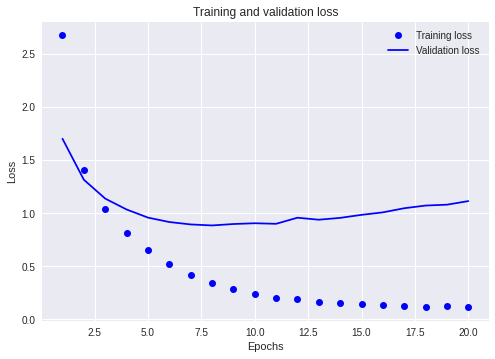

In [82]:
plt.clf()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

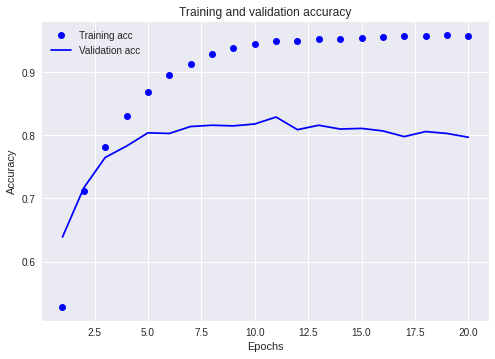

In [83]:
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## 6. Retrain the model with 9 epochs


In [84]:
model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(46, activation='softmax'))

model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

model.fit(partial_x_train, partial_y_train, epochs=9, batch_size=512, validation_data=(x_val, y_val))

# evaluation on test dataset phase
results = model.evaluate(x_test, one_hot_test_labels)

Epoch 1/9
16/16 [==============================] - 0s 31ms/step - loss: 2.8792 - accuracy: 0.4788 - val_loss: 1.8938 - val_accuracy: 0.6430
Epoch 2/9
16/16 [==============================] - 0s 21ms/step - loss: 1.5043 - accuracy: 0.6982 - val_loss: 1.3150 - val_accuracy: 0.7150
Epoch 3/9
16/16 [==============================] - 0s 21ms/step - loss: 1.0657 - accuracy: 0.7781 - val_loss: 1.1153 - val_accuracy: 0.7740
Epoch 4/9
16/16 [==============================] - 0s 20ms/step - loss: 0.8244 - accuracy: 0.8321 - val_loss: 1.0101 - val_accuracy: 0.8000
Epoch 5/9
16/16 [==============================] - 0s 20ms/step - loss: 0.6518 - accuracy: 0.8695 - val_loss: 0.9897 - val_accuracy: 0.7910
Epoch 6/9
16/16 [==============================] - 0s 21ms/step - loss: 0.5308 - accuracy: 0.8939 - val_loss: 0.9260 - val_accuracy: 0.8050
Epoch 7/9
16/16 [==============================] - 0s 21ms/step - loss: 0.4217 - accuracy: 0.9149 - val_loss: 0.8999 - val_accuracy: 0.8060
Epoch 8/9
16/16 [===

In [85]:
print(f"Results on test set. Loss: {results[0]}, Accuracy: {results[1]}")

Results on test set. Loss: 1.0127917528152466, Accuracy: 0.7813891172409058


## 7. Prediction on test set

Now we can use the trained model to predict unseen data (test data).
The ouput of the `predict()` method of the model instance returns a probability
distribution over all 46 topics.


In [86]:
model.predict(x_test)

array([[1.39318336e-05, 8.76342019e-05, 1.10643341e-05, ...,
        2.73886690e-05, 2.25555846e-06, 8.36293566e-07],
       [2.75311060e-03, 8.17807671e-03, 1.60298035e-01, ...,
        3.20072897e-04, 3.91859248e-05, 2.12336378e-03],
       [1.52852992e-02, 8.67380083e-01, 1.45816978e-03, ...,
        4.08410502e-04, 2.59808567e-05, 5.14826097e-04],
       ...,
       [1.36221370e-05, 2.30424266e-04, 4.38392235e-05, ...,
        5.18124216e-05, 1.46890907e-05, 4.56202633e-06],
       [3.90747888e-03, 8.17185491e-02, 8.48500989e-03, ...,
        6.55843003e-04, 1.92637468e-04, 5.21746173e-04],
       [3.76672787e-03, 8.90879035e-01, 3.83414305e-03, ...,
        6.95296680e-04, 1.13549635e-04, 3.49095382e-04]], dtype=float32)